In [1]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from utils import ImageDataset, SaveFeatures, accuracy, imshow_transform
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline


###################
# Hyperparameters #

n_samples = 10000
n_samples_train = int(round(n_samples*0.8))
n_samples_val = int(round(n_samples*0.2))
batch_size = 15
current_computer =   "ubuntu" # "macbook" # 
layers_to_freeze = 0
lr = 0.00001
weight_decay=0.04
num_epochs = 10
im_size = 200
min_palsa_positive_samples = 10


##########################
# log hyperparams to w&b #

run = wandb.init(
    # Set the project where this run will be logged
    project="VGG_CAMs",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "n_samples": n_samples,
        "layers_to_freeze": layers_to_freeze,
        "weight_decay": weight_decay,
        "im_size": im_size,
        "min_palsa_positive_samples": min_palsa_positive_samples
    },
    tags=['4D', 'LRScheduler', 'MSELoss', 'TrainFromScratch', 'CAMloss']
)

#############
# Load data #

if current_computer == "ubuntu":
    hs_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/hs'
    RGB_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/rgb'
    labels_file = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/palsa_labels.csv'
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/200m/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/200m/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/200m/palsa_labels.csv'

# Load the labels from the CSV file
if min_palsa_positive_samples > 0:
    labels_df = pd.read_csv(labels_file, index_col=0)
    drop_range = labels_df[ (labels_df['palsa_percentage'] > 0) & (labels_df['palsa_percentage'] < min_palsa_positive_samples) ].index

    labels_df.drop(drop_range, inplace=True)
    labels_df = labels_df.head(n_samples)
else: 
    labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)


# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(hs_dir, RGB_dir, train_df, im_size)
val_dataset = ImageDataset(hs_dir, RGB_dir, val_df, im_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


In [2]:
################
# Define model 

model = model_4D()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.92)
loss_function = nn.CrossEntropyLoss()

In [3]:
##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

max_val_acc = 0

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(images).to(device)  
        percent_labels = Variable(labels[0].long()/100).to(device)  
        binary_labels = Variable(labels[1].long()).to(device)  

        # prep feature saving
        lastconv = SaveFeatures(model.features[-4])

        # train batch   
        outputs = model(images) 
        optimizer.zero_grad()

        # WEIGH THE LOSS BY THE BINARY LABELS 

        lastconv_act = lastconv.features.cpu().detach()
        palsa_maps = lastconv_act[:, 1, :, :].to(device)
        act_map_size = palsa_maps.shape[1] * palsa_maps.shape[2] 
        activation_threshold = palsa_maps.mean() + torch.std(palsa_maps)
        pixels_activated = torch.where(palsa_maps > activation_threshold, 1, 0)
        percent_activated = torch.sum(pixels_activated, dim = (1,2)) / act_map_size

        percent_loss = torch.sum((percent_labels - percent_activated)**2)
        regular_loss = loss_function(outputs, binary_labels)
        loss = percent_loss + regular_loss
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        train_acc.append(accuracy(outputs, binary_labels.long()))
        running_loss += loss.item()
        train_batch_count += 1

    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):     

            # load images and labels 
            images = Variable(images).to(device)  
            percent_labels = Variable(labels[0].long()/100).to(device)  
            binary_labels = Variable(labels[1].long()).to(device)  
            outputs = model(images) 
            loss = loss_function(outputs, binary_labels)

            val_acc.append(accuracy(outputs, binary_labels))
            val_running_loss += loss.item()
            val_batch_count +=1

    scheduler.step()

    # update losses and accuracies 
    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    wandb.log({"train_accuracy": np.mean(train_acc)})
    wandb.log({"val_accuracy": np.mean(val_acc)})
    wandb.log({"train_loss": running_loss/train_batch_count})
    wandb.log({"val_loss": val_running_loss/val_batch_count})

    if np.mean(val_acc) > max_val_acc:
        best_model = model.state_dict()
        max_val_acc = np.mean(val_acc)

torch.save(best_model, '/home/nadjaflechner/models/model.pth')
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/home/nadjaflechner/models/model.pth')
run.log_artifact(artifact)


EPOCH:  1


/home/nadjaflechner/miniconda3/envs/torch_only_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10


<Artifact model>

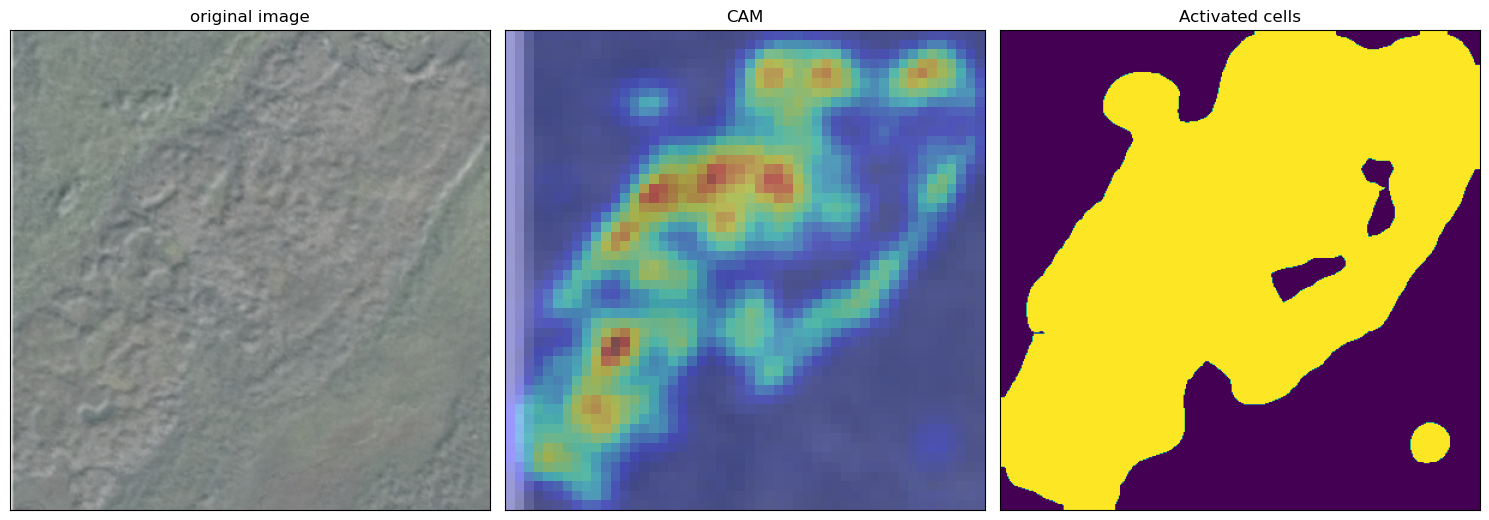

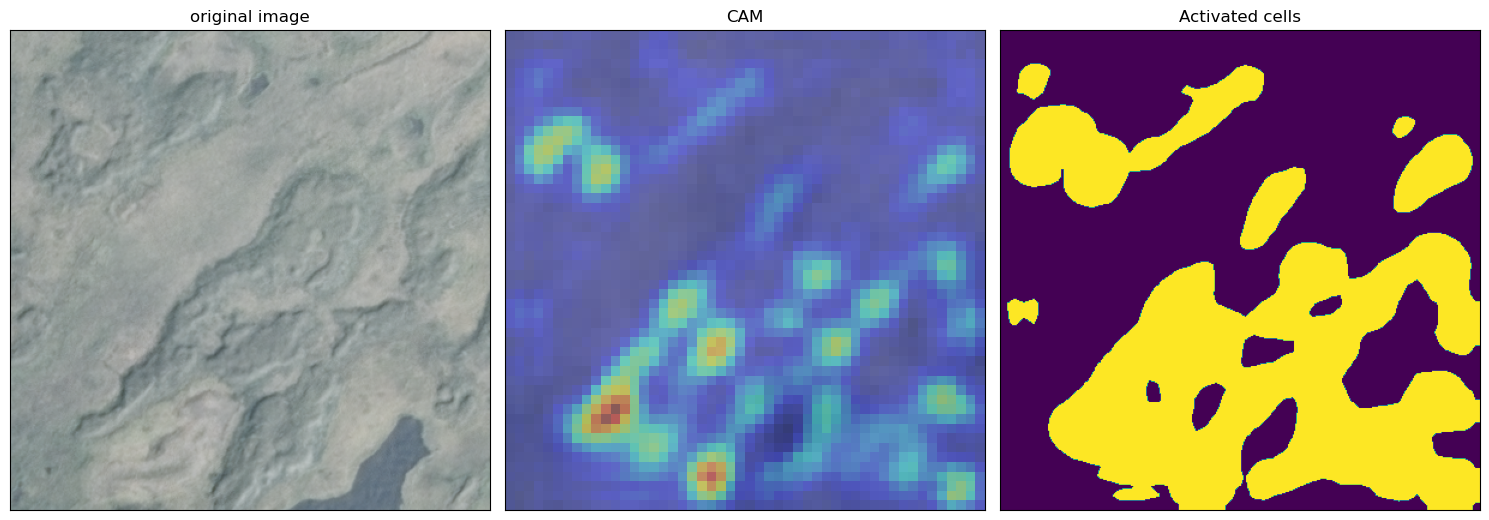

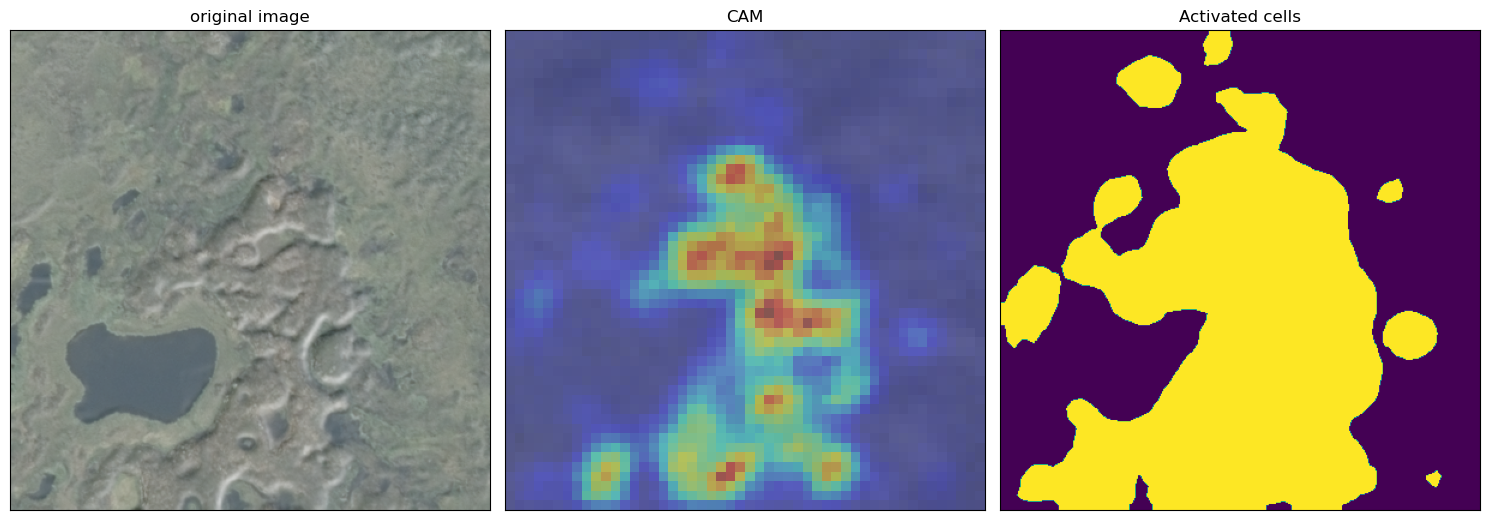

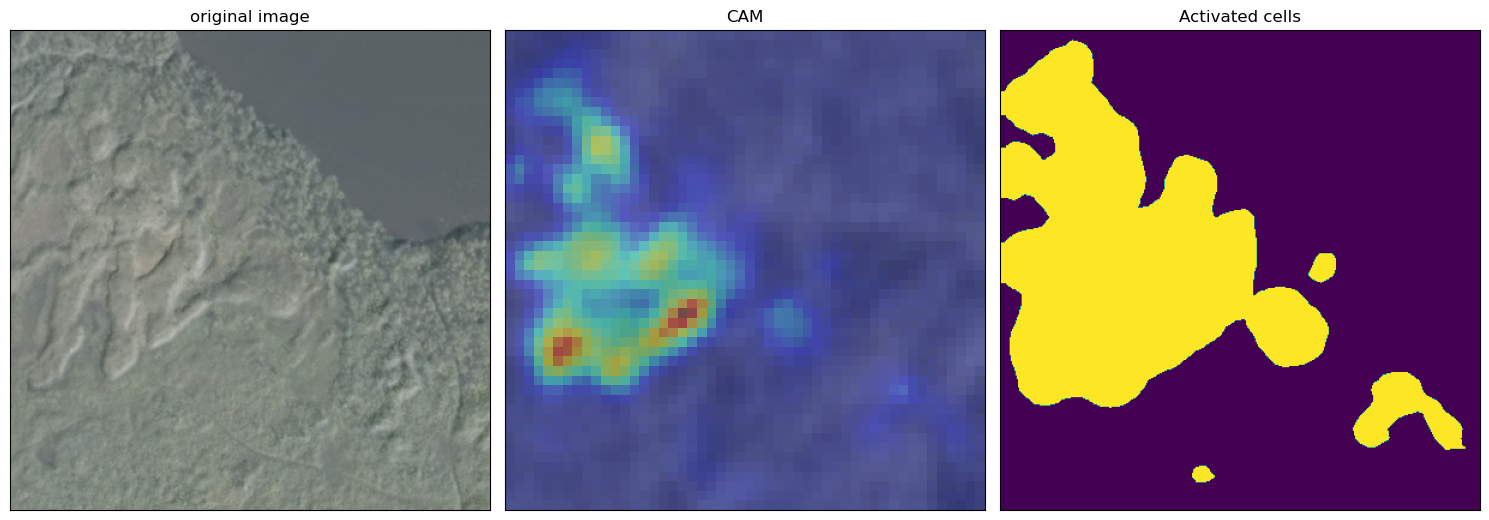

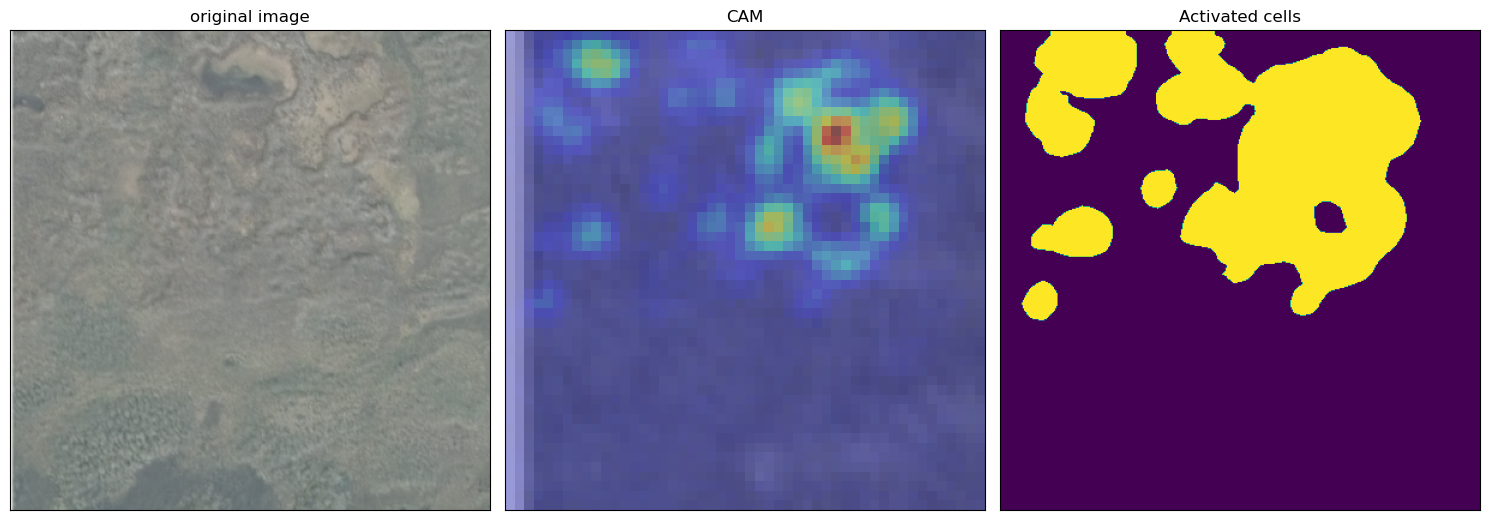

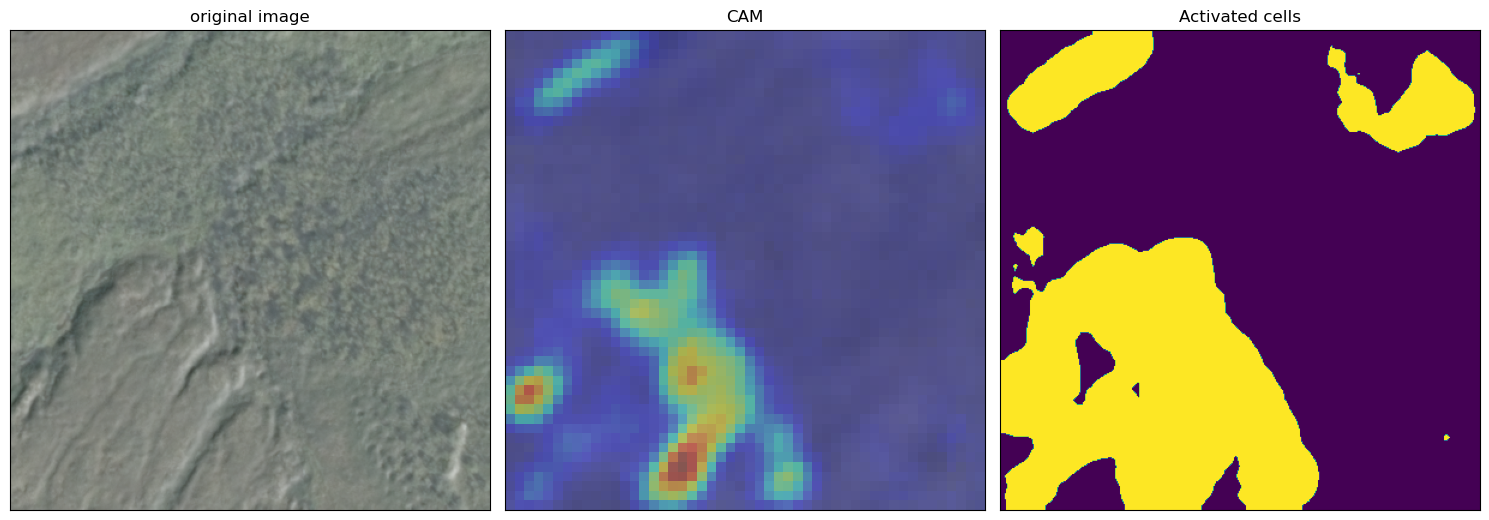

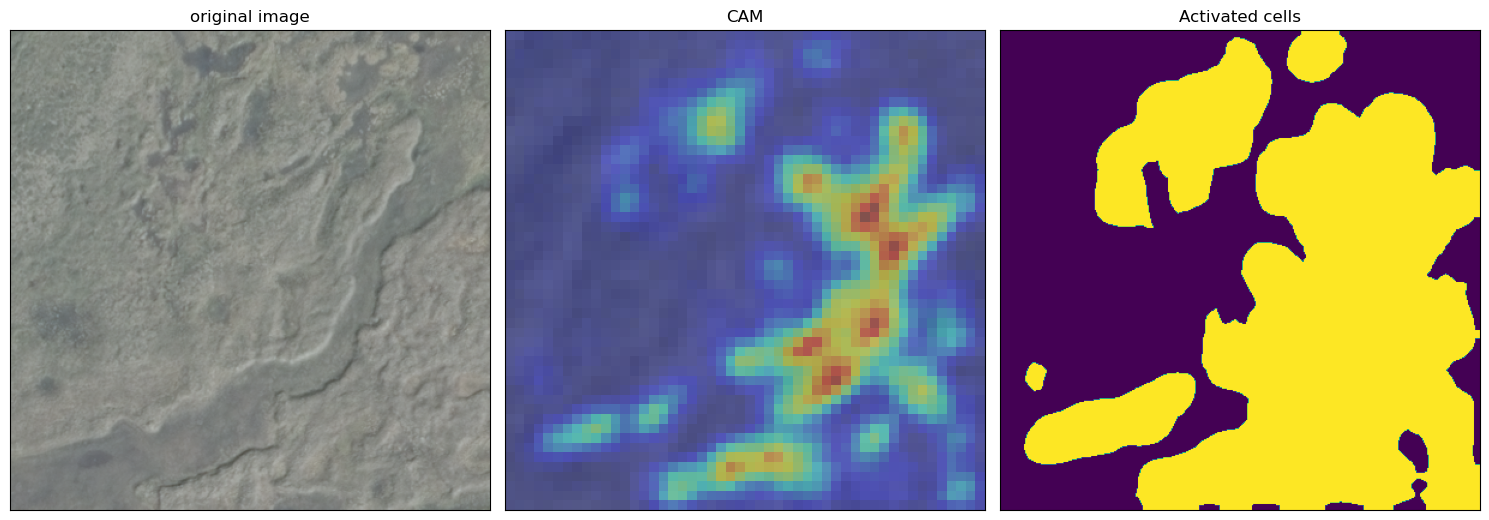

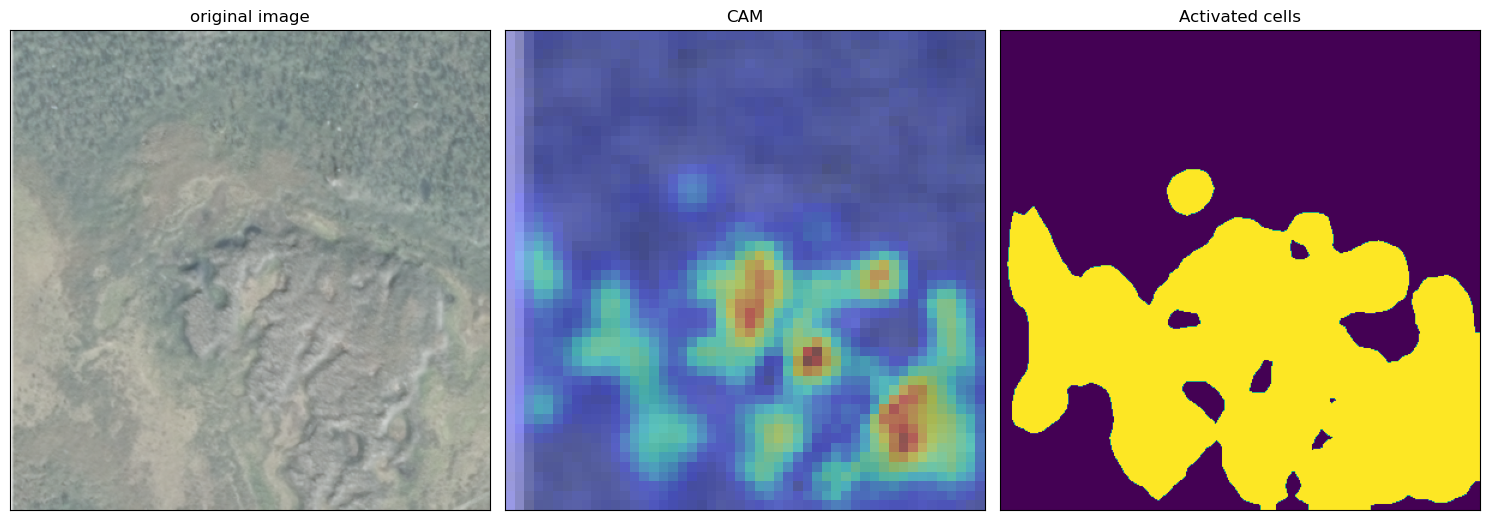

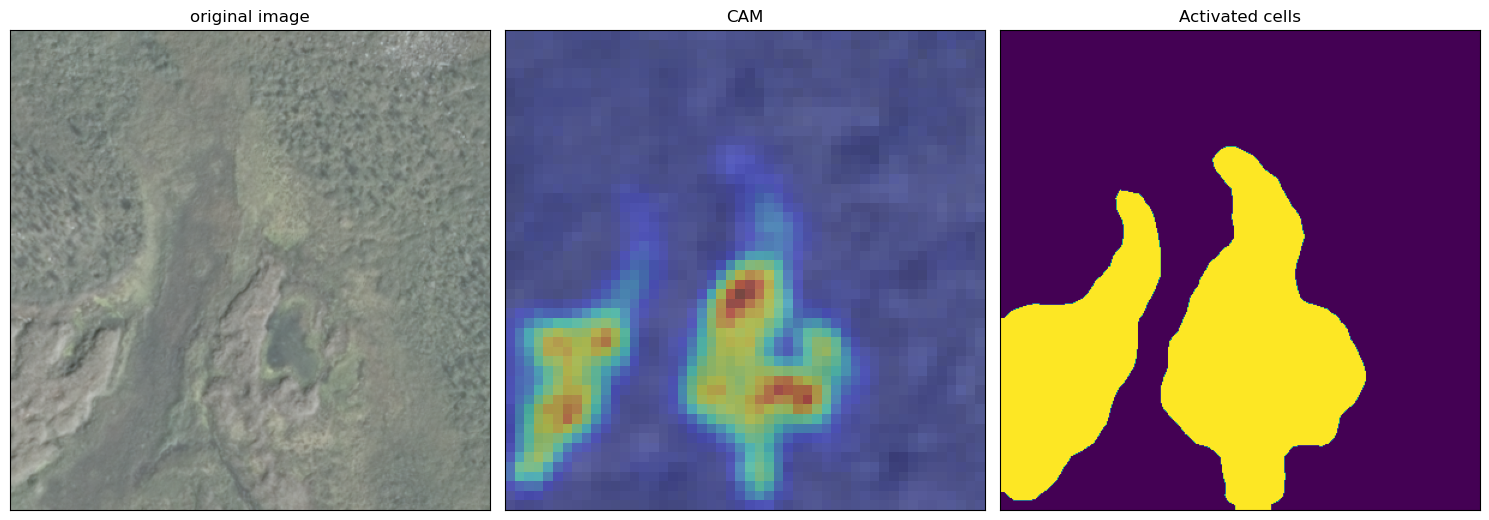

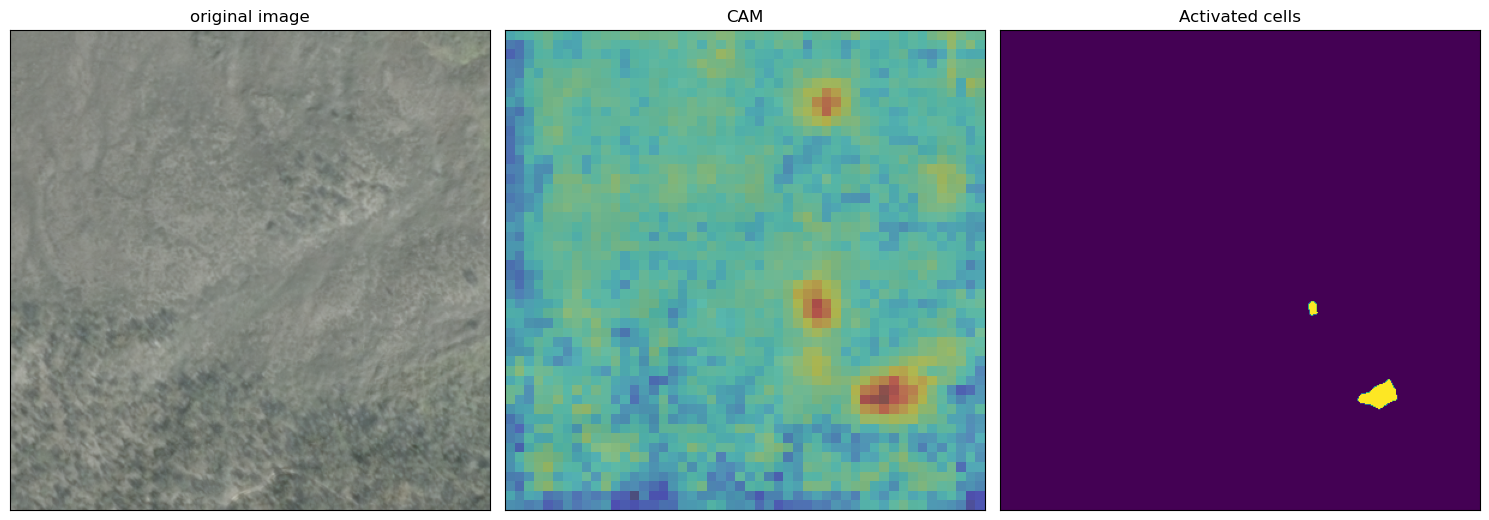

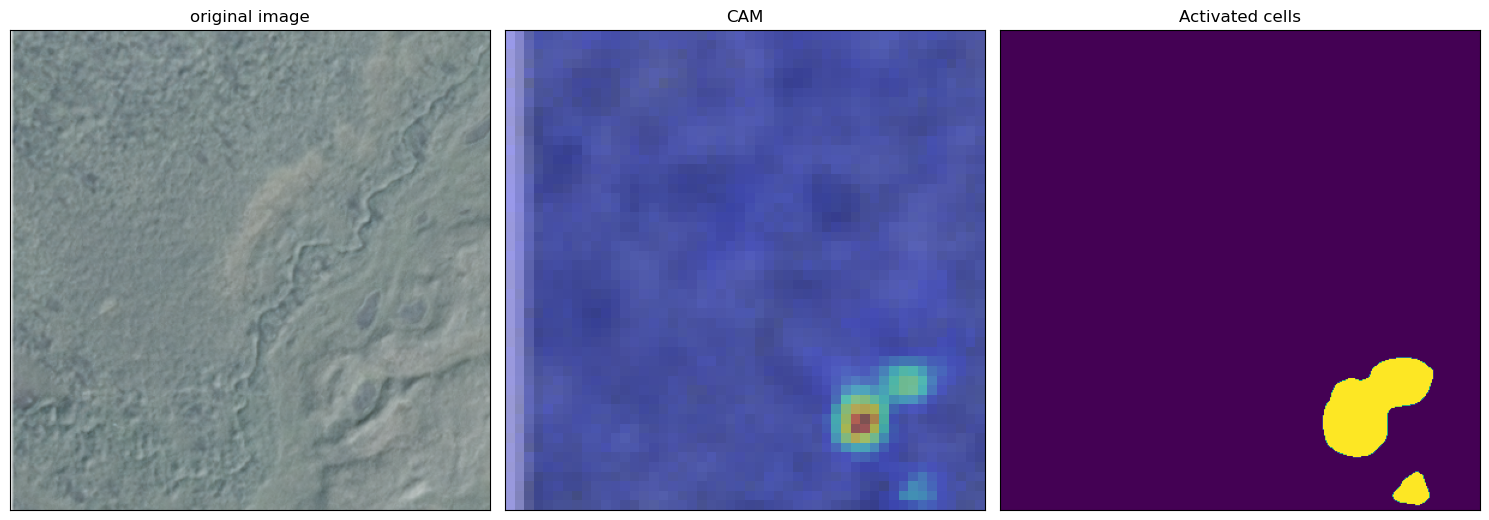

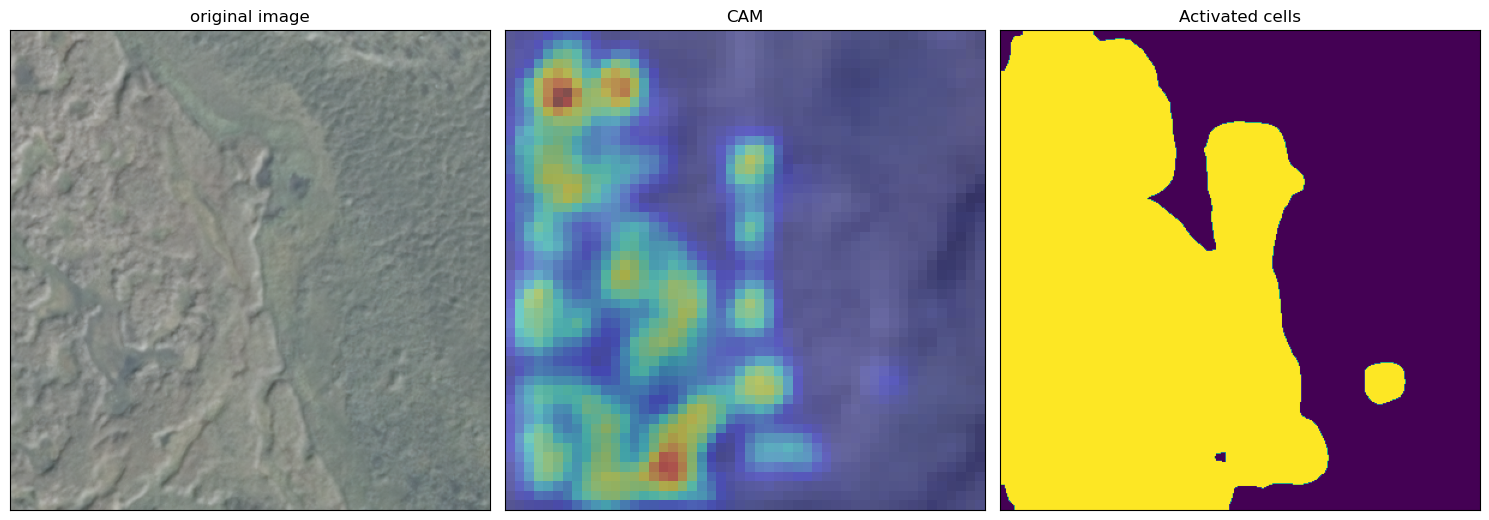

In [12]:
from skimage.transform import resize
from skimage.io import imshow

####################
# generating CAMs #

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images
palsa_imgs = 0
for palsa_cam in range(100):
    im, (percent_label, binary_label) = next(iter(valid_loader))

    #get the last convolution
    sf = SaveFeatures(model.features[-4])
    model.eval()

    if binary_label == 1:
        palsa_imgs+= 1

        im = Variable(im).to(device)
        outputs = model(im).to(device)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach()#.numpy()

        pals_acts = torch.nn.functional.interpolate(
                                            arr[:,1,:,:].unsqueeze(1), 
                                            scale_factor = im.shape[3]/arr.shape[3], 
                                            mode='bilinear').cpu().detach()
        activation_threshold = pals_acts.mean() + torch.std(pals_acts)
        pixels_activated = torch.where(torch.Tensor(pals_acts) > activation_threshold.cpu(), 1, 0).squeeze(0).permute(1,2,0).numpy()

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,6))

        ax1.imshow(cpu_img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title(f'original image')

        ax2.imshow(cpu_img)
        ax2.imshow(pals_acts.view(im.shape[3], im.shape[3], 1), alpha=.4, cmap='jet')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('CAM')

        ax3.imshow(cpu_img)
        ax3.imshow(pixels_activated)
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('Activated cells')

        plt.tight_layout()

        wandb.log({'generated_CAM': fig})

    if palsa_imgs == 20:
        break

### PLOTTING TO FIND GOOD ACTIVATION THRESHOLD

In [5]:
while True:
    im, (percent_label, binary_label) = next(iter(valid_loader))
    if binary_label == 1:
        break

In [33]:
arr[:,1,:,:].numpy().shape

pals_acts = resize(arr[:,1,:,:].numpy(), (im_size*2,im_size*2))


(1, 50, 50)

In [39]:
arr[:,1,:,:].shape

torch.Size([1, 50, 50])

In [43]:
pixels_activated

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]])

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


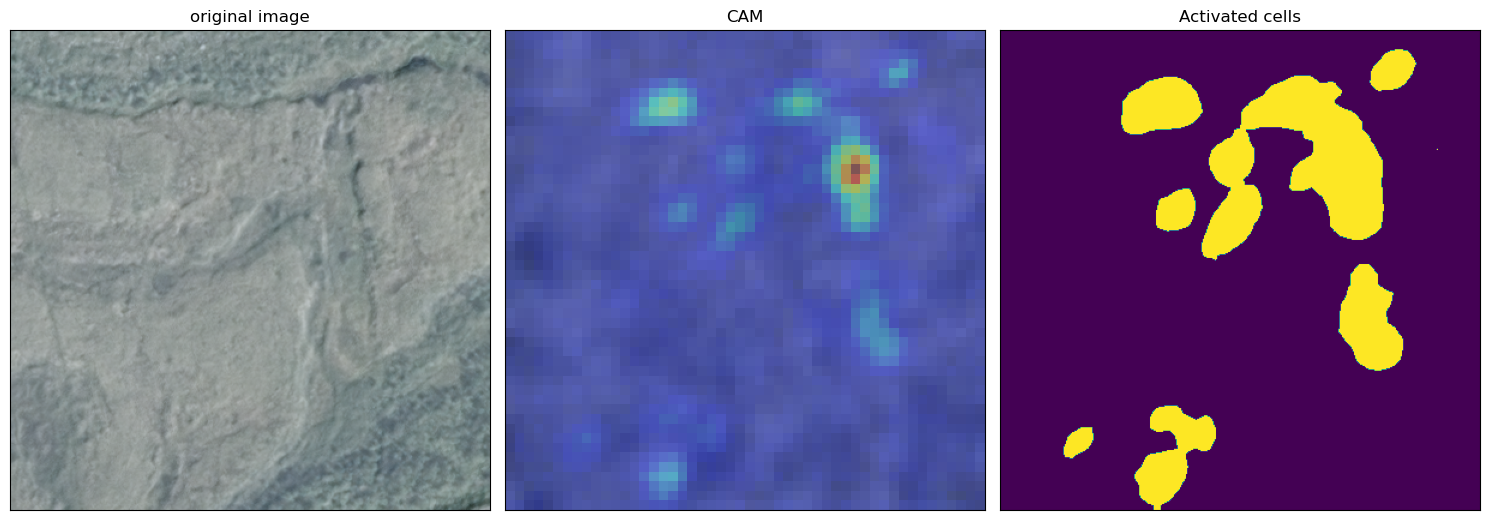

In [52]:
sf = SaveFeatures(model.features[-4])
im = Variable(im).to(device)
outputs = model(im).to(device)

# generate CAM
sf.remove()
arr = sf.features.cpu().detach()#.numpy()

pals_acts = torch.nn.functional.interpolate(
                                    arr[:,1,:,:].unsqueeze(1), 
                                    scale_factor = im.shape[3]/arr.shape[3], 
                                    mode='bilinear')
activation_treshold = pals_acts.mean() + torch.std(pals_acts)/2
pixels_activated = torch.where(torch.Tensor(pals_acts) > activation_threshold, 1, 0).squeeze(0).permute(1,2,0).numpy()

# Plot image with CAM
cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,6))

ax1.imshow(cpu_img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(f'original image')

ax2.imshow(cpu_img)
ax2.imshow(np.transpose(arr[:,1,:,:],(1,2,0)), alpha=.4, cmap='jet')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('CAM')

ax3.imshow(cpu_img)
ax3.imshow(pixels_activated)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Activated cells')

plt.tight_layout()



In [13]:
wandb.finish()